# Kalman-like Filtering for baseball stats
## Data analysis workbook

This notebook is a data exploration and analysis for my attempt to use Kalman filtering to make forward looking and uncertain predictions of player-skill evolution.

I'm ripping off the Baseball Reference WAR data, which is [available from their website](https://www.baseball-reference.com/data/war_daily_bat.txt).

First, I'm going to load the data from the file I've generated in another notebook, and do some prep so everything in the code works as expected. I also will cull the data here so we are only looking at qualifying batters (ones with more than 502 PAs in a given season).

In [1]:
# imports 
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde

# prep for tufte ready plots
sns.set(style= 'ticks', palette= 'Set2');
# sns.despine();

# prep for latex-like plots
plt.rc('text', usetex= True);
plt.rc('font', family= 'serif');
plt.rc('axes.spines',
       top= False,
       bottom= False,
       left= False,
       right= False);

# file of interest
filename_in= 'deltaWAR.txt';
# filename_in= '/Users/coryfrontin/Documents/Baseball Research/KalmanFilteredStats/deltaWAR.txt';

# read csv using pandas
rawData= pd.read_csv(filename_in);

# drop extaneous column
rawData= rawData.drop(rawData.filter(regex= 'Unnamed').columns, axis= 1);

# filter for qualifying players ... at least 502 PAs
data= rawData[rawData['PA'] > 502].copy();

# view
data.head()

G     Inn  OPS_plus     PA   WAR   age  lastG  lastInn  lastOPS_plus  \
0  153.0  1346.0  141.3379  665.0  6.25  21.0  122.0   1031.0      103.8311   
1  153.0  1349.3  150.6159  660.0  7.18  22.0  153.0   1346.0      141.3379   
2  151.0  1356.3  166.1340  675.0  7.97  23.0  153.0   1349.3      150.6159   
3  153.0  1361.0  152.4043  664.0  7.32  24.0  151.0   1356.3      166.1340   
4  154.0  1368.7  182.3185  693.0  8.64  25.0  153.0   1361.0      152.4043   

   lastPA  lastWAR  player_ID  retires  year_ID  deltaWAR  deltaOPS_plus  
0   509.0     1.27  aaronha01    False     1955      4.98        37.5068  
1   665.0     6.25  aaronha01    False     1956      0.93         9.2780  
2   660.0     7.18  aaronha01    False     1957      0.79        15.5181  
3   675.0     7.97  aaronha01    False     1958     -0.65       -13.7297  
4   664.0     7.32  aaronha01    False     1959      1.32        29.9142

$\newcommand\WAR{\mathrm{WAR}} \newcommand\OPSp{\mathrm{OPS+}}$
We can see above a sampling of the data that was previously generated. The key thing here is that we have data for $\WAR$ (`WAR`) and $\OPSp$ (`OPS_plus`) for every sophomore or greater player-season, the age of that player for that season, which we will denote with $t$ (`age`), and we have the performance data from the player's previous season, $\WAR_\mathrm{prev}$ (`WAR`) and $\OPSp_\mathrm{prev}$ (`lastOPS_plus`).

We will furthermore denote, for a given player $p$, a datum $y$ from player's $i$<sup>th</sup> player-season will be denoted by $y^p_i$, and frequently, we will omit the $p$ and just write $y_i$. From here, we calculate $\Delta \WAR$ and $\Delta \OPSp$, which are given by:
$$\Delta \WAR= \WAR_i - \WAR_{i - 1}$$
and
$$\Delta \OPSp= \OPSp_i - \OPSp_{i - 1}$$
(in the code `deltaWAR` and `deltaOPS_plus`).

Last but not least, we also will look at the change in WAR normalized by the previous year's $\WAR$:
$$\frac{\Delta \WAR}{\WAR_{i - 1}}= \frac{\WAR_i}{\WAR_{i = 1}} - 1$$

In [2]:
data['deltaWAR']= data.WAR - data.lastWAR;
data['deltaOPS_plus']= data.OPS_plus - data.lastOPS_plus;
data['deltaWARperLastWAR']= data.deltaWAR/data.lastWAR;

With data in hand, we will take a look at how all these things vary. The immediate question that comes to mind is what the predictive power of $\WAR_{i - 1}$ on $\WAR$ is. The below plot takes a swing at answering that question:

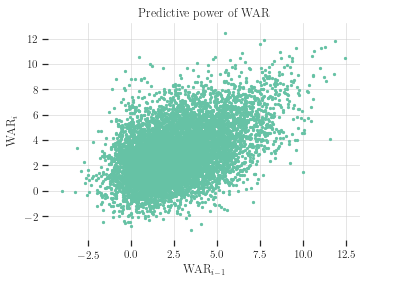

In [3]:
fig= plt.figure();

# ax= fig.add_subplot(111, aspect= 9./16.);
ax= fig.gca();
plt.scatter(data.lastWAR, data.WAR, s= 5.0);
plt.title("Predictive power of $\mathrm{WAR}$");
plt.xlabel("$\mathrm{WAR}_{i - 1}$");
plt.ylabel("$\mathrm{WAR}_i$");
plt.grid(alpha= 0.5);

divider= make_axes_locatable(ax);
cax= divider.append_axes("right", size="5%", pad=0.1);

# cax.set_axis_bgcolor('none');
for axis in ['top','bottom','left','right']:
    cax.spines[axis].set_linewidth(0);
cax.set_xticks([]);
cax.set_yticks([]);

# cb= plt.colorbar(cax= cax);
plt.savefig('../../Saberseminar2019/lecture/graphics/WAR2WAR.pdf',
#             bbox_inches= 'tight',
            transparent= True);
plt.show();

We can see that there is a significant correlation between the performance in one season ($\WAR_{i - 1}$) to the next ($\WAR_i$). With that said, it's not perfect prediction, it's a pretty decent spread. Even 10 $\WAR$ seasons- very rarefied air- can be followed by season anywhere from 1 $\WAR$ to 12.

We can glean further insight by looking at the effect on age on this spread, which we now do by looking at the same plot but with colorization by age:

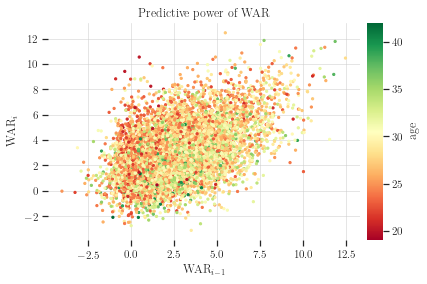

In [4]:
def linfitfun(x, a, b):
    return a*x + b;

# out= opt.curve_fit(linfitfun, data.lastWAR, data.WAR, (0.0, 0.0));
# a= out[0][0];
# b= out[0][1];

fig= plt.figure();

# ax= fig.add_subplot(111, aspect= 9./16.);
ax= fig.gca();
plt.scatter(data.lastWAR, data.WAR, c= data.age, s= 5.0,
            cmap= plt.cm.get_cmap('RdYlGn'));
plt.title("Predictive power of $\mathrm{WAR}$");
plt.xlabel("$\mathrm{WAR}_{i - 1}$");
plt.ylabel("$\mathrm{WAR}_i$");
plt.grid(alpha= 0.5);
# axesToHold= plt.gca().axis();

# plt.plot(np.array((-5., 13.)), a*np.array((-5., 13.)) + b, '--', c= 'dimgrey');
# plt.axis(axesToHold);

divider= make_axes_locatable(ax);
cax= divider.append_axes("right", size="5%", pad=0.1);

cb= plt.colorbar(cax= cax);
cb.set_label('age');
cb.outline.set_visible(False);
plt.savefig('../../Saberseminar2019/lecture/graphics/WAR2WAR_age.pdf',
#             bbox_inches= 'tight',
            transparent= True);

We can see that there is some substantial effect of aging on the predictive power of $\WAR$ from one season to the next; younger players tend to have higher value in their $i$<sup>th</sup> season than in their $(i - 1)$<sup>th</sup> one. With that said, there is still substantial spread in the motion from one year to the next. In parallel, we can see that there is an aging effect on $\WAR$ itself, seen by plotting the player-seasons of $\WAR$ as a function of age.

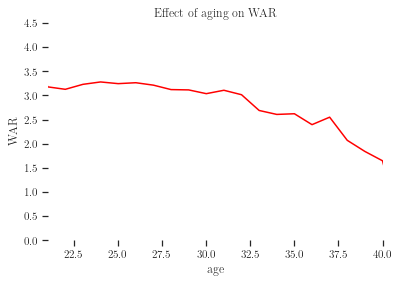

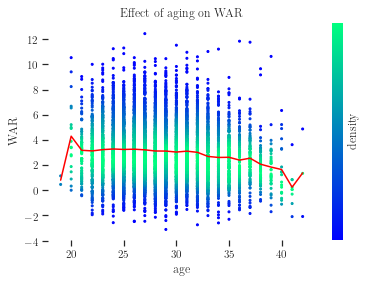

In [5]:
ax= None;
# ax= data.plot.scatter(x= 'age', y= 'WAR', s= 2.0);
data.groupby('age').mean().plot(y= 'WAR',
                                c= "Red",
                                label= '$\mathrm{mean}(\mathrm{WAR})$',
                                legend= None,
                                ax= ax);
plt.title("Effect of aging on $\mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\mathrm{WAR}$");
plt.axis((21, 40, 0, 4.5));
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveWAR.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

ax= None;

meanData= data.groupby('age', as_index= False).mean();

for age in data.age.unique():
    plotData= data[data['age'] == age];
    N_age= len(plotData);
    
    x= plotData.age;
    y= plotData.WAR;
    z= gaussian_kde(y)(y);
    
    plt.scatter(x= x, y= y, s= 4.0, c= z,
                cmap= plt.cm.get_cmap('winter'));

plt.plot(meanData.age, meanData.WAR, 'red',
         label= '$\mathrm{mean}(\mathrm{WAR})$');

plt.title("Effect of aging on $\mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\mathrm{WAR}$");

cb= plt.colorbar();
cb.set_label("density");
cb.outline.set_visible(False);
cb.set_ticks([]);

plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveWARscatter.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

# ax= data.plot.scatter(x= 'age', y= 'WAR', s= 4.0);
# data.groupby('age').mean().plot(y= 'WAR',
#                                 c= "Magenta",
#                                 label= '$\mathrm{mean}(\mathrm{WAR})$',
#                                 legend= None,
#                                 ax= ax);
# plt.title("Effect of aging on $\mathrm{WAR}$");
# plt.xlabel("age");
# plt.ylabel("$\mathrm{WAR}$");
# plt.savefig('../Saberseminar2019/lecture/graphics/agingCurveWARscatter.pdf',
#             bbox_inches= 'tight',
#             transparent= True);
# plt.show();

We can make a few observations here. First of all, we observe that the red line constitutes the data that would be used to create a "Delta method" classical aging curve to predict a given player's aging. However, given any datapoint at age $(i - 1)$ on these distributions, not all of the datapoints on the age $i$ distribution are created equal. For instance, we can see that, though there are variations, players tend to occupy the same part of the distributions from one year to the next:

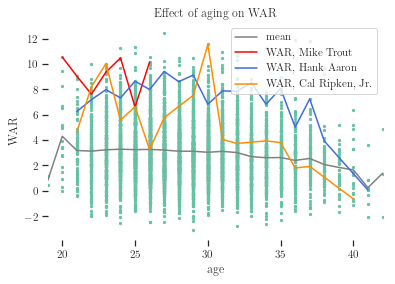

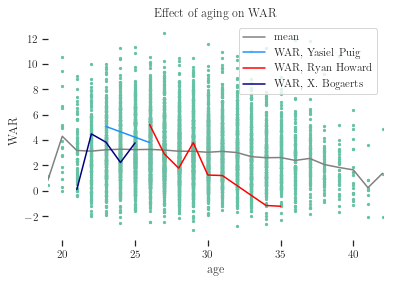

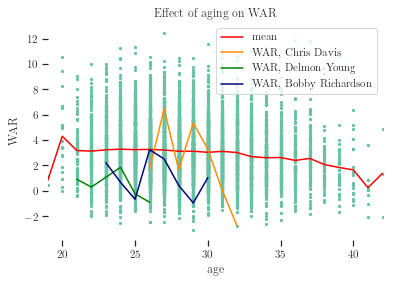

In [6]:
ax= data.plot.scatter(x= 'age', y= 'WAR', s= 5.0);
data.groupby('age').mean().plot(y= 'WAR',
                                c= "grey",
                                label= 'mean',
                                ax= ax);
data[data['player_ID'] == 'troutmi01'].plot(x= 'age', y= 'WAR',
                                            c= "red",
                                            label= "$\mathrm{WAR}$, Mike Trout",
                                            ax= ax);
data[data['player_ID'] == 'aaronha01'].plot(x= 'age', y= 'WAR',
                                            c= "royalblue",
                                            label= "$\mathrm{WAR}$, Hank Aaron",
                                            ax= ax);
data[data['player_ID'] == 'ripkeca01'].plot(x= 'age', y= 'WAR',
                                            c= "darkorange",
                                            label= "$\mathrm{WAR}$, Cal Ripken, Jr.",
                                            ax= ax);
plt.title("Effect of aging on $\mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\mathrm{WAR}$");
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveWARscatter_HOF.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

ax= data.plot.scatter(x= 'age', y= 'WAR', s= 5.0);
data.groupby('age').mean().plot(y= 'WAR',
                                c= "grey",
                                label= 'mean',
                                ax= ax);
data[data['player_ID'] == 'puigya01'].plot(x= 'age', y= 'WAR',
                                          c= "dodgerblue",
                                          label= "$\mathrm{WAR}$, Yasiel Puig",
                                          ax= ax);
data[data['player_ID'] == 'howarry01'].plot(x= 'age', y= 'WAR',
                                            c= "red",
                                            label= "$\mathrm{WAR}$, Ryan Howard",
                                            ax= ax);
data[data['player_ID'] == 'bogaexa01'].plot(x= 'age', y= 'WAR',
                                            c= "navy",
                                            label= "$\mathrm{WAR}$, X. Bogaerts",
                                            ax= ax);
plt.title("Effect of aging on $\mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\mathrm{WAR}$");
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveWARscatter_OK.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

ax= data.plot.scatter(x= 'age', y= 'WAR', s= 5.0);
data.groupby('age').mean().plot(y= 'WAR',
                                c= "Red",
                                label= 'mean',
                                ax= ax);
data[data['player_ID'] == 'davisch02'].plot(x= 'age', y= 'WAR',
                                            c= "darkorange",
                                            label= "$\mathrm{WAR}$, Chris Davis",
                                            ax= ax);
data[data['player_ID'] == 'youngde03'].plot(x= 'age', y= 'WAR',
                                            c= "green",
                                            label= "$\mathrm{WAR}$, Delmon Young",
                                            ax= ax);
data[data['player_ID'] == 'richabo01'].plot(x= 'age', y= 'WAR',
                                            c= "navy",
                                            label= "$\mathrm{WAR}$, Bobby Richardson",
                                            ax= ax);
plt.title("Effect of aging on $\mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\mathrm{WAR}$");
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveWARscatter_YUCK.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

So, now, we return to the notion that $\WAR_{i - 1}$ has considerable prediction power on $\WAR_i$, with a notable dependence on age. Now, we can look at the effect of aging on $\Delta \WAR$ and $\Delta \WAR/\WAR_{i - 1}$.

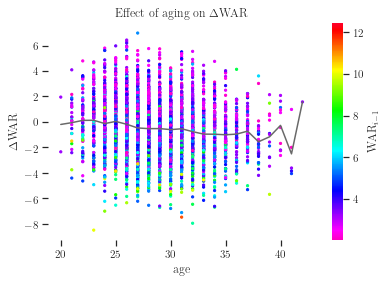

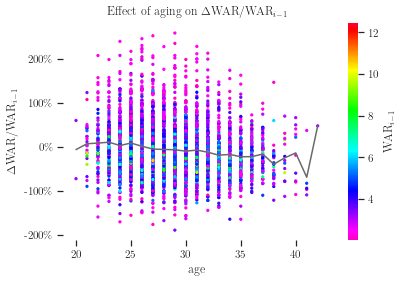

In [7]:
plotData= data[data['lastWAR'] > 2.0];
meanData= plotData.groupby('age', as_index= False).mean()

plt.figure();
plt.plot(meanData.age, meanData.deltaWAR, 'dimgray');
plt.scatter(x= plotData.age, y= plotData.deltaWAR,
            c= plotData.lastWAR, s= 5.0,
            cmap= plt.cm.get_cmap('gist_rainbow_r'));
plt.title("Effect of aging on $\Delta \mathrm{WAR}$");
plt.xlabel("age");
plt.ylabel("$\Delta \mathrm{WAR}$");
cb= plt.colorbar();
cb.set_label('$\mathrm{WAR}_{i - 1}$');
cb.outline.set_visible(False);
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveDeltaWARscatter.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

plt.figure();
plt.plot(meanData.age, meanData.deltaWARperLastWAR, 'dimgray');
plt.scatter(x= plotData.age, y= plotData.deltaWARperLastWAR,
            c= plotData.lastWAR, s= 5.0,
            cmap= plt.cm.get_cmap('gist_rainbow_r'));
plt.title("Effect of aging on $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.xlabel("age");
plt.ylabel("$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.gca().yaxis.set_major_formatter(tick.PercentFormatter(1.0));
cb= plt.colorbar();
cb.set_label('$\mathrm{WAR}_{i - 1}$');
cb.outline.set_visible(False);
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveDeltaWARperLastWARscatter.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();


In the first plot, we can see that, as should be expected, the distribution of $\Delta \WAR$ has a dependence on the previous season's $\WAR$, seen from the colorization. However, by normalizing by $\WAR_{i - 1}$, we finally find a scheme for which the distribution is relatively independent of the previous season's $\WAR$.


Moreover, we note that the mean curve- which can be thought of as the classical Delta method curve- is well defined, and tends to increase up through around the age 30 season, after which it decreases. Now, we can look at how these distibutions vary when we filter for various bands of $\WAR_{i - 1}$:

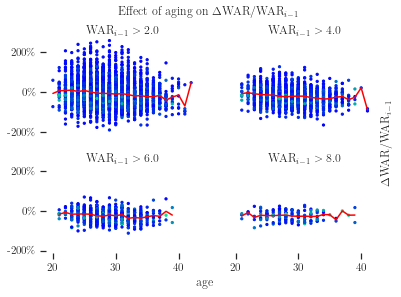

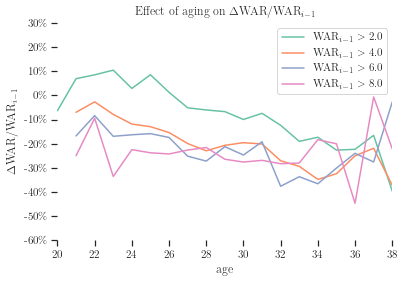

In [8]:
fig, axes= plt.subplots(2, 2, sharex= 'all', sharey= 'all');

plotData= data[data['lastWAR'] > 2.0];
meanData= plotData.groupby('age', as_index= False).mean()

axes[0, 0].scatter(plotData.age, plotData.deltaWARperLastWAR,
                 c= plotData.lastWAR, s= 5.0,
                 cmap= plt.cm.get_cmap('winter'));
axes[0, 0].plot(meanData.age, meanData.deltaWARperLastWAR, 'red');
axes[0, 0].set_title("$\mathrm{WAR}_{i - 1} > 2.0$", y= 0.95);
axes[0, 0].xaxis.set_visible(False);
axes[0, 0].yaxis.set_major_formatter(tick.PercentFormatter(1.0));


plotData= data[data['lastWAR'] > 4.0];
meanData= plotData.groupby('age', as_index= False).mean()

axes[0, 1].scatter(plotData.age, plotData.deltaWARperLastWAR,
                 c= plotData.lastWAR, s= 5.0,
                 cmap= plt.cm.get_cmap('winter'));
axes[0, 1].plot(meanData.age, meanData.deltaWARperLastWAR, 'red');
axes[0, 1].set_title("$\mathrm{WAR}_{i - 1} > 4.0$", y= 0.95);
axes[0, 1].xaxis.set_visible(False);
axes[0, 1].yaxis.set_visible(False);

plotData= data[data['lastWAR'] > 6.0];
meanData= plotData.groupby('age', as_index= False).mean()

axes[1, 0].scatter(plotData.age, plotData.deltaWARperLastWAR,
                 c= plotData.lastWAR, s= 5.0,
                 cmap= plt.cm.get_cmap('winter'));
axes[1, 0].plot(meanData.age, meanData.deltaWARperLastWAR, 'red');
axes[1, 0].set_title("$\mathrm{WAR}_{i - 1} > 6.0$", y= 0.85);
axes[1, 0].yaxis.set_major_formatter(tick.PercentFormatter(1.0));

plotData= data[data['lastWAR'] > 8.0];
meanData= plotData.groupby('age', as_index= False).mean()

axes[1, 1].scatter(plotData.age, plotData.deltaWARperLastWAR,
                 c= plotData.lastWAR, s= 5.0,
                 cmap= plt.cm.get_cmap('winter'));
axes[1, 1].plot(meanData.age, meanData.deltaWARperLastWAR, 'red');
axes[1, 1].set_title("$\mathrm{WAR}_{i - 1} > 8.0$", y= 0.85);
axes[1, 1].yaxis.set_visible(False);

# create fake major plot for common axes labels
fig.add_subplot(111, frameon= False);
plt.tick_params(labelcolor= 'none', top= False, bottom= False, left= False, right= False);
plt.xlabel('age', x= 0.475);
plt.ylabel('$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$', labelpad= 0.5);
plt.gca().yaxis.set_label_position("right");

plt.suptitle("Effect of aging on $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveDeltaWARperLastWARscatter_WARbreakout.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

plt.figure();
plotData= data[data['lastWAR'] > 2.0];
meanData= plotData.groupby('age', as_index= False).mean()
plt.plot(meanData.age, meanData.deltaWARperLastWAR,
         label= '$\mathrm{WAR}_{i - 1} > 2.0$');

plotData= data[data['lastWAR'] > 4.0];
meanData= plotData.groupby('age', as_index= False).mean()
plt.plot(meanData.age, meanData.deltaWARperLastWAR,
         label= '$\mathrm{WAR}_{i - 1} > 4.0$');

plotData= data[data['lastWAR'] > 6.0];
meanData= plotData.groupby('age', as_index= False).mean()
plt.plot(meanData.age, meanData.deltaWARperLastWAR,
         label= '$\mathrm{WAR}_{i - 1} > 6.0$');

plotData= data[data['lastWAR'] > 8.0];
meanData= plotData.groupby('age', as_index= False).mean()
plt.plot(meanData.age, meanData.deltaWARperLastWAR,
         label= '$\mathrm{WAR}_{i - 1} > 8.0$');

plt.axis((20, 38, -0.6, 0.3));
plt.title("Effect of aging on $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.xlabel('age');
plt.ylabel('$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$');
plt.gca().yaxis.set_major_formatter(tick.PercentFormatter(1.0));
plt.legend();
plt.savefig('../../Saberseminar2019/lecture/graphics/agingCurveDeltaWARperLastWARscatter_WARmean.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

From here, we can see that as the value of $\WAR_{i - 1}$ gets higher, two things happen:
* the variances of the distributions about each age decrease
* the mean functions get progressively lower and their slopes decrease
If these two things are true, we only need to ensure that the transition from performances $\Delta \WAR/\WAR_{i - 1}$ are randomly distributed from any given season with $\WAR_{i - 1}$ to another.

To show some evidence that this is the case, we'll take a look at the career trajectories of the same players as before on this plot.

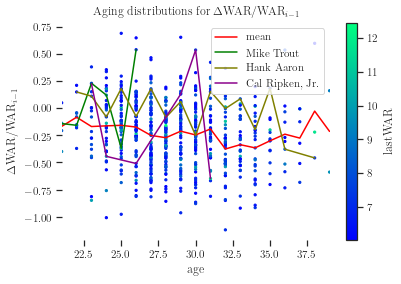

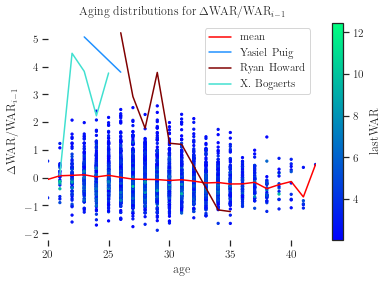

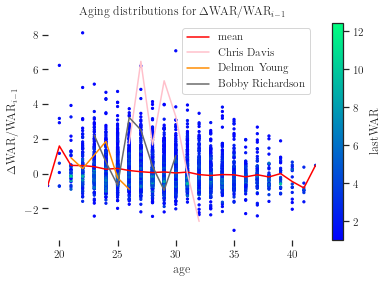

In [9]:
plotData= data[data['lastWAR'] > 6.0];
ax= plotData.plot.scatter(x= 'age', y= 'deltaWARperLastWAR',
                          s= 5.0, c= 'lastWAR',
                          cmap= plt.cm.get_cmap("winter"));
plotData.groupby('age').mean().plot(y= 'deltaWARperLastWAR',
                                    c= "Red",
                                    label= "mean",
                                    ax= ax);
plotData[plotData['player_ID'] == 'troutmi01'].plot(x= 'age', y= 'deltaWARperLastWAR',
                                                    c= "green",
                                                    label= "Mike Trout",
                                                    ax= ax);
plotData[plotData['player_ID'] == 'aaronha01'].plot(x= 'age', y= 'deltaWARperLastWAR',
                                                    c= "olive",
                                                    label= "Hank Aaron",
                                                    ax= ax);
plotData[plotData['player_ID'] == 'ripkeca01'].plot(x= 'age', y= 'deltaWARperLastWAR',
                                                    c= "darkmagenta",
                                                    label= "Cal Ripken, Jr.",
                                                    ax= ax);
plt.title("Aging distributions for $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.xlabel("age");
plt.ylabel("$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.show();

plotData= data[data['lastWAR'] > 2.0];
ax= plotData.plot.scatter(x= 'age', y= 'deltaWARperLastWAR',
                          s= 5.0, c= 'lastWAR',
                          cmap= plt.cm.get_cmap("winter"));
plotData.groupby('age').mean().plot(y= 'deltaWARperLastWAR',
                                    c= "Red",
                                    label= "mean",
                                    ax= ax);
data[data['player_ID'] == 'puigya01'].plot(x= 'age', y= 'WAR',
                                            c= "dodgerblue",
                                            label= "Yasiel Puig",
                                            ax= ax);
data[data['player_ID'] == 'howarry01'].plot(x= 'age', y= 'WAR',
                                            c= "maroon",
                                            label= "Ryan Howard",
                                            ax= ax);
data[data['player_ID'] == 'bogaexa01'].plot(x= 'age', y= 'WAR',
                                            c= "turquoise",
                                            label= "X. Bogaerts",
                                            ax= ax);
plt.title("Aging distributions for $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.xlabel("age");
plt.ylabel("$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.show();

plotData= data[data['lastWAR'] > 1.0];
ax= plotData.plot.scatter(x= 'age', y= 'deltaWARperLastWAR',
                          s= 5.0, c= 'lastWAR',
                          cmap= plt.cm.get_cmap("winter"));
plotData.groupby('age').mean().plot(y= 'deltaWARperLastWAR',
                                    c= "Red",
                                    label= "mean",
                                    ax= ax);
data[data['player_ID'] == 'davisch02'].plot(x= 'age', y= 'WAR',
                                            c= "pink",
                                            label= "Chris Davis",
                                            ax= ax);
data[data['player_ID'] == 'youngde03'].plot(x= 'age', y= 'WAR',
                                            c= "darkorange",
                                            label= "Delmon Young",
                                            ax= ax);
data[data['player_ID'] == 'richabo01'].plot(x= 'age', y= 'WAR',
                                            c= "dimgrey",
                                            label= "Bobby Richardson",
                                            ax= ax);
plt.title("Aging distributions for $\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.xlabel("age");
plt.ylabel("$\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1}$");
plt.show();


In all, we can now say, roughly, that we have defined a set of distributions and can write a process that will do a good job of describing the evolution- in a probabilistic sense- of a player's $\WAR$ from one year to the next:
1. get the player's data from the previous season, $\WAR_{i - 1}$.
2. get the player's age in the $(i - 1)$<sup>th</sup> season.
3. find the distribution curve for $\frac{\Delta \WAR}{\WAR_{i - 1}}$ using an appropriate band around their $\WAR_{i - 1}$ at that age.
4. estimate $\WAR_i$ by:
$\newcommand\WARratioModel{\left(\frac{\Delta \WAR}{\WAR_{i - 1}}\right)_\mathrm{RV}}$
$$\WAR_i= \WAR_{i - 1} + \WARratioModel \WAR_{i - 1}$$
where, in effect, $\WARratioModel$ is a random variable (or the expectation of a random variable) of the distribution found in (3).

In order to apply this process more succinctly, we will formulate a model for a probability distribution function to be used for $\WARratioModel$ that is a function of $\WAR_{i - 1}$ and player age.

To do so, we will create a maximum likelihood estimator function to fit probability density functions to the data we have here. We start with a Gaussian function:
$$p(x)= f(x; \beta_1, \beta_2)= \frac{1}{\sqrt{2 \pi \beta_2}} \exp{- \frac{(x - \beta_1)^2}{2 \beta_2}}$$
with parameters $\beta_1= \mu$, the mean, and $\beta_2= \sigma^2$, the variance.

In [10]:
def fit_pdf_MLE(x_samples, guess= float('nan'), pdf= 'gauss'):
    
    # set initial guess based on PDF
    if isinstance(guess, float) and np.isnan(guess):
        if pdf == 'gauss':
            guess= (1.0, 1.0);
        else:
            error("pdf undefined");
    
    # pdf function
    def logpdf(x, beta, pdf):
        
        # gaussian function
        if pdf == 'gauss':
            
            # unpack parameters
            
            # validate
            assert(len(beta) == 2);
            
            # unpack
            mu= beta[0]; # mu
            var= np.exp(beta[1]); # beta[1]= log(var)

            # the log of the probability (better for numerics)
            logp= -0.5*np.log(2*math.pi*var) - (x - mu)**2/(2*var);

            return logp;
        else:
            error("pdf undefined");
            return

    # likelihood calculation
    def calculate_loglikelihood(x_in, beta, pdf):

        # initialize
        logL= 0.0;

        # loop over the samples handed in
        for x in x_in:
            # likelihood of all the samples is the product
            # of the probabilities or the sum of the logprobabilities
            logp= logpdf(x, beta, pdf);

            # add the logprobability to the loglikelihood
            logL= logL + logp;

        # return the log likelihood
        return logL

    # want to maximize likelihood aka minimize negloglikelihood
    def calculate_negloglikelihood(beta, x_in, pdf):

        # calculate the loglikelihood
        logL= calculate_loglikelihood(x_in, beta, pdf);
        logL= -logL;
        
        # return the newly flipped thing
        return logL;
    
    # ship to the optimizer
    beta_solve= opt.fmin(calculate_negloglikelihood,
                         guess,
                         args= (x_samples, 'gauss'),
                         xtol= 1e-12, ftol= 1e-12,
                         disp= False);
    
    return beta_solve;

This gives us the ability to fit Gaussian distributions for any given age and $\WAR_{i - 1}$ range. With this capability, we can put together a table of means and variances for all possible ages, with bands of $\WAR$ every 2.0 $\WAR$ from 2 $\WAR$, with an open interval above 8. We tabulate the results in the table `modelData` below.

In [11]:
# get the unique ages
ages= sorted(data.age.unique());

# WAR bracketing cutoffs
WARcutoffs= [2.0, 4.0, 6.0, 8.0];
N_cutoffs= len(WARcutoffs);
# threshold for histograms + models
nToModel= 10;

ageSeries= ();
WARbinSeries= ();
meanSeries= ();
varSeries= ();
NSeries= ();
meanLastWARseries= ();

doPlot= False;

# loop over the ages that we have
for age in ages:
    
    # get data for the model
    ageData= data[data['age'] == age];
    ageData= ageData[ageData['lastWAR'] > 0.0]
    
    # make sure this age has enough qualifiers
    if len(ageData) < nToModel:
        continue

    if doPlot:
        # start a figure
        plt.figure()
        
    # histogram the occurances of dWAR/WAR
    N_bins= 100;
    if doPlot:
        ax= ageData.hist(column= 'deltaWARperLastWAR',
                         bins= N_bins,
                         density= True);
    
    # loop over all of the bins
    for i in range(N_cutoffs):
        
#         print "doing age %d bin %d." % (age, i);
        
        # get the band of WARs
        WARlo= WARcutoffs[i];
        if (i == N_cutoffs - 1): # for the last bin
            WARhi= float('inf'); # it goes on forever!
        else:
            WARhi= WARcutoffs[i + 1];

        
        # cut down to the WAR band
        ageDataCut= ageData[ageData['lastWAR'] >= WARlo]
        ageDataCut= ageDataCut[ageDataCut['lastWAR'] < WARhi]
        
        # make sure this age has enough qualifiers
        if len(ageDataCut) < nToModel:
            continue
        
        if doPlot:
            # histogram the occurances of dWAR/WAR
            ageDataCut.hist(column= 'deltaWARperLastWAR',
                            alpha= 0.25, bins= N_bins,
                            ax= ax,
                            density= True);
        
        # fit a Gaussian
        beta_solve= fit_pdf_MLE(ageDataCut.deltaWARperLastWAR);

        # get the stats
        mean= beta_solve[0];
        var= np.exp(beta_solve[1]);
        
        N= len(ageDataCut.deltaWARperLastWAR);
        meanLastWAR= np.mean(ageDataCut.lastWAR);
                        
        ageSeries= ageSeries + (age,);
        WARbinSeries= WARbinSeries + (i,);
        meanSeries= meanSeries + (mean,);
        varSeries= varSeries + (var,);
        NSeries= NSeries + (N,);
        meanLastWARseries= meanLastWARseries + (meanLastWAR,);
        
    if doPlot:
        plt.show();

# stash data for the model in a dataframe
modelData= pd.DataFrame({'age': ageSeries,
                         'WARbin': WARbinSeries,
                         'meanDeltaWARperLastWAR': meanSeries,
                         'varDeltaWARperLastWAR': varSeries,
                         'meanLastWAR': meanLastWARseries,
                         'N': NSeries});

# get the average WAR in a bin
binMeanLastWAR= np.zeros(N_cutoffs);
for i in range(N_cutoffs):
    working_data= modelData[modelData['WARbin'] == i];
    Nsum= 0.0;
    WARsum= 0.0;
    for j in range(len(working_data)):
        NtoAdd= working_data.N.values[j];
        WARtoAdd= working_data.meanLastWAR.values[j];
        
        Nsum= Nsum + NtoAdd;
        WARsum= WARsum + NtoAdd*WARtoAdd;
    binMeanLastWAR[i]= WARsum/Nsum; # back to the raw average


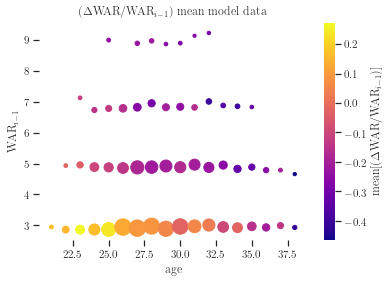

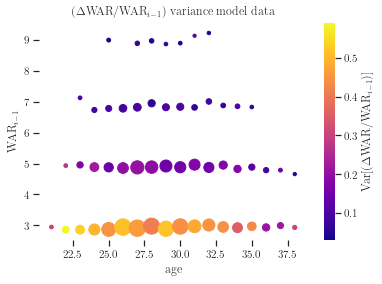

In [12]:
fig= plt.figure();
plt.scatter(x= modelData.age, y= modelData.meanLastWAR,
            c= modelData.meanDeltaWARperLastWAR,
            s= modelData.N,
            cmap= plt.cm.get_cmap('plasma'));
plt.title('$(\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1})$ mean model data');
plt.xlabel('age');
plt.ylabel('$\mathrm{WAR}_{i - 1}$');
cb= plt.colorbar();
cb.set_label('$\mathrm{mean}[(\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1})]$');
cb.outline.set_visible(False);
plt.savefig('../../Saberseminar2019/lecture/graphics/model_meanSurface.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();

fig= plt.figure();
plt.scatter(x= modelData.age, y= modelData.meanLastWAR,
            c= modelData.varDeltaWARperLastWAR,
            s= modelData.N,
            cmap= plt.cm.get_cmap('plasma'));
plt.title('$(\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1})$ variance model data');
plt.xlabel('age');
plt.ylabel('$\mathrm{WAR}_{i - 1}$');
cb= plt.colorbar();
cb.set_label('$\mathrm{Var}[(\Delta \mathrm{WAR}/\mathrm{WAR}_{i - 1})]$');
cb.outline.set_visible(False);
plt.savefig('../../Saberseminar2019/lecture/graphics/model_varianceSurface.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();


In [13]:
modelData

N  WARbin   age  meanDeltaWARperLastWAR  meanLastWAR  \
0    14       0  21.0                0.168588     2.947857   
1    46       0  22.0                0.155829     2.863043   
2    14       1  22.0               -0.027848     4.934286   
3    80       0  23.0                0.272039     2.861875   
4    40       1  23.0               -0.038336     4.957226   
5    14       2  23.0               -0.122100     7.127143   
6   123       0  24.0                0.170058     2.867178   
7    78       1  24.0               -0.099723     4.887051   
8    27       2  24.0               -0.145029     6.734074   
9   193       0  25.0                0.239730     2.869745   
10   85       1  25.0               -0.112156     4.878000   
11   37       2  25.0               -0.126361     6.782973   
12   15       3  25.0               -0.237803     8.994000   
13  270       0  26.0                0.130391     2.946268   
14  116       1  26.0               -0.142222     4.856207   
15   58       2  26.0               -0.160546     6.787414   
16  269       0  27.0                0.092339     2.910803   
17  174       1  27.0               -0.178278     4.876609   
18   60       2  27.0               -0.259954     6.821333   
19   20       3  27.0               -0.226528     8.890000   
20  256       0  28.0                0.089996     2.976847   
21  156       1  28.0               -0.209837     4.885577   
22   52       2  28.0               -0.293993     6.950577   
23   20       3  28.0               -0.215864     8.969500   
24  231       0  29.0                0.056948     2.891196   
25  144       1  29.0               -0.204446     4.921250   
26   49       2  29.0               -0.198564     6.822041   
27   13       3  29.0               -0.264509     8.866154   
28  238       0  30.0               -0.023447     2.964843   
29  125       1  30.0               -0.169907     4.882130   
30   50       2  30.0               -0.238942     6.837200   
31   14       3  30.0               -0.276021     8.895714   
32  165       0  31.0                0.057164     2.971013   
33  121       1  31.0               -0.203203     4.965022   
34   32       2  31.0               -0.166127     6.816562   
35   10       3  31.0               -0.269087     9.135000   
36  147       0  32.0                0.030529     3.012126   
37  102       1  32.0               -0.224634     4.874608   
38   31       2  32.0               -0.411452     7.008710   
39   12       3  32.0               -0.285530     9.224167   
40  115       0  33.0               -0.093119     2.949841   
41   67       1  33.0               -0.253362     4.951642   
42   22       2  33.0               -0.357390     6.879545   
43   98       0  34.0               -0.022618     2.926173   
44   53       1  34.0               -0.332107     4.827547   
45   22       2  34.0               -0.399260     6.853182   
46   75       0  35.0               -0.153021     2.969655   
47   39       1  35.0               -0.324909     4.885897   
48   13       2  35.0               -0.333228     6.830000   
49   54       0  36.0               -0.204603     2.934234   
50   28       1  36.0               -0.253907     4.786786   
51   38       0  37.0               -0.136099     2.994089   
52   15       1  37.0               -0.196252     4.788000   
53   18       0  38.0               -0.414790     2.933599   
54   11       1  38.0               -0.466289     4.660000   

    varDeltaWARperLastWAR  
0                0.298698  
1                0.590576  
2                0.274572  
3                0.539723  
4                0.175552  
5                0.091481  
6                0.500357  
7                0.225543  
8                0.095945  
9                0.449763  
10               0.142060  
11               0.099348  
12               0.029443  
13               0.514360  
14               0.199372  
15               0.088037  
16               0.463143  
17               0.204861  
1

For simplicity's sake we will start by using a nearest neighbor interpolation to the model dataset.

In [14]:
def nearestNeighborModelData(age, lastWAR, modelData):
    N_rows= len(modelData);
    
    idxAge= np.argmin(np.abs(modelData.age.to_numpy() - age));
    age= modelData.age[idxAge];
    
    newData= modelData[modelData['age'] == age];
    
    idxWAR= np.argmin(np.abs(newData.meanLastWAR.to_numpy() - lastWAR));
    lastWAR= newData.meanLastWAR.to_numpy()[idxWAR];
    
    mean= newData.meanDeltaWARperLastWAR.to_numpy()[idxWAR];
    var= newData.varDeltaWARperLastWAR.to_numpy()[idxWAR];
    
    print "matched to data:"
    print "\tage: %f" % age
    print "\tlastWAR: %f" % lastWAR
    
    return (mean, var)

eldest davisch02 season:
	age: 32
	WAR: -2.750000
matched to data:
	age: 33.000000
	lastWAR: 2.949841
	model mean interpolation: -0.093119
	model variance interpolation: 0.444003
[-0.6615005  -2.49392404 -4.32634758]


<Figure size 432x288 with 0 Axes>

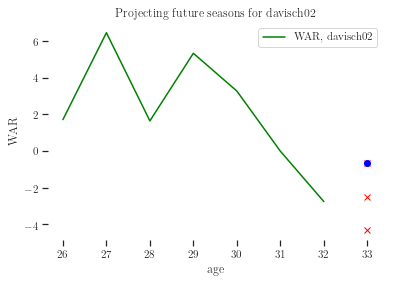

In [15]:
player_ID= 'davisch02';
troutData= data[data['player_ID'] == player_ID];

age_eldestTrout= max(troutData.age);
WAR_eldestTrout= troutData[troutData['age'] == age_eldestTrout].WAR.to_numpy();

print "eldest " + player_ID + " season:";
print "\tage: %d" % age_eldestTrout;
print "\tWAR: %f" % WAR_eldestTrout;

(model_mean, model_var)= nearestNeighborModelData(age_eldestTrout + 1, WAR_eldestTrout, modelData);

print "\tmodel mean interpolation: %f" % model_mean;
print "\tmodel variance interpolation: %f" % model_var;

plt.figure();
ax= troutData.plot(x= 'age', y= 'WAR',
                   c= "green",
                   label= "$\mathrm{WAR}$, " + player_ID);

deltaWARperWAR= np.array([model_mean - np.sqrt(model_var), model_mean, model_mean + 1*np.sqrt(model_var)]);
WARpred= WAR_eldestTrout + deltaWARperWAR*WAR_eldestTrout;
print WARpred;

ax.plot((age_eldestTrout + 1)*np.ones(len(WARpred)), WARpred, 'rx');
# ax.axis([19, 28, 2, 14]);

ax.plot((age_eldestTrout + 1),
        rawData[(rawData['player_ID'] == player_ID) & (rawData['age'] == (age_eldestTrout + 1))].WAR, 'bo');

ax.axis('auto');

plt.title('Projecting future seasons for ' + player_ID);
plt.xlabel('age');
plt.ylabel('$\mathrm{WAR}$');

plt.show();

It appears that these functions both vary roughly linearly with age and- again, roughly- decay exponentially as $\WAR_{i - 1}$ increases. We can encapsulate that in a model for the value of $\WARratioModel$ as a function of player's age $t$ and their previous season $\WAR$:
$$\left. \WARratioModel \right|_{(t, \WAR_{i - 1})} \sim \mathcal{N}(f(t, \WAR_{i - 1}), g(t, \WAR_{i - 1}))$$
and where we can define:
$$f(t, \WAR_{i - 1})= (-\exp(a_f \WAR_{i - 1} + b_f))*(c_f t + d_f)$$
$$g(t, \WAR_{i - 1})= \left[(-\exp(a_g \WAR_{i - 1} + b_g))*(c_g t + d_g)\right]^2$$

(No longer...
$$f(t, \WAR_{i - 1})= -\exp(a_{m, f} \WAR_{i - 1} + c_{m, f}) t + \exp(a_{b, f} \WAR_{i - 1} + c_{b, f})$$
$$g(t, \WAR_{i - 1})= -\exp(a_{m, g} \WAR_{i - 1} + c_{m, g}) t + \exp(a_{b, g} \WAR_{i - 1} + c_{b, g})$$)

This is a modeling step. We make a couple assumptions:
* the value of $\WARratioModel$ is drawn from a Gaussian distribution whose mean and variances vary as functions of age and previous season $\WAR$.
* the mean function $f$ and the variance function $g$ are each assumed to be linear with respect to age, $t$.
* across all ages $t$, it is assumed that $\log(f)$ and $\log(g)$ are linear functions of $\WAR_{i - 1}$.
* $\lim_{\WAR_{i - 1} \to \infty} f$ and $\lim_{\WAR_{i - 1} \to \infty} g$ are constants.

In [16]:
# def WARratioModelDist(age, lastWAR, beta):
#     aMeanWARslope= beta[0]; # a_{m, f}
#     cMeanWARslope= beta[1]; # c_{m, f}
#     aMeanWARint= beta[2];   # a_{b, f}
#     cMeanWARint= beta[3];   # c_{b, f}
#     aVarWARslope= beta[4];  # a_{m, g}
#     cVarWARslope= beta[5];  # c_{m, g}
#     aVarWARint= beta[6];    # a_{b, g}
#     cVarWARint= beta[7];    # c_{b, g}
    
#     f= -np.exp(aMeanWARslope*lastWAR + cMeanWARslope)*age + np.exp(aMeanWARint*lastWAR + cMeanWARint);
#     g= (-np.exp(aVarWARslope*lastWAR + cVarWARslope)*age + np.exp(aVarWARint*lastWAR + cVarWARint))**2;
#     return (f, g);

def WARratioModelDist(age, lastWAR, beta, clean= True):    
    a_f= beta[0];
    b_f= beta[1];
    c_f= beta[2];
    d_f= beta[3];
    e_f= beta[4];
    f_f= beta[5];
    a_g= beta[6];
    b_g= beta[7];
    c_g= beta[8];
    d_g= beta[9];
    e_g= beta[10];
    f_g= beta[11];
    g_g= beta[12];
    h_g= beta[13];
#     i_g= beta[14];
#     j_g= beta[15];
    
    if clean:
        lastWAR= max((0.5, lastWAR));
    
    f= ((np.exp(a_f*lastWAR + b_f) + c_f)*age + (np.exp(d_f*lastWAR + e_f) + f_f));
    g= abs((np.exp(a_g*lastWAR**2 + b_g*lastWAR + c_g) + d_g)*age + (np.exp(e_g*lastWAR**2 + f_g*lastWAR + g_g) + h_g));
    
    return (f, g);

def WARratioModelDist0(age, lastWAR, clean= True):
    
    beta= (-7.18922088e-01, -2.49443137e+00, -2.18830188e-02,  1.10730199e+00,
       -1.50543591e+01,  3.73435088e-01,  4.28799439e-02, -8.93678298e-01,
       -2.04802569e+00, -4.39137061e-03, -2.07093735e+01, -2.63089915e+00,
        8.79284197e+01, -1.58946442e-01);
    
    a_f= beta[0];
    b_f= beta[1];
    c_f= beta[2];
    d_f= beta[3];
    e_f= beta[4];
    f_f= beta[5];
    a_g= beta[6];
    b_g= beta[7];
    c_g= beta[8];
    d_g= beta[9];
    e_g= beta[10];
    f_g= beta[11];
    g_g= beta[12];
    h_g= beta[13];
#     i_g= beta[14];
#     j_g= beta[15];
    
    if clean:
        lastWAR= max((2.0, lastWAR));
    
    f= ((np.exp(a_f*lastWAR + b_f) + c_f)*age + (np.exp(d_f*lastWAR + e_f) + f_f));
    g= abs((np.exp(a_g*lastWAR**2 + b_g*lastWAR + c_g) + d_g)*age - (np.exp(e_g*lastWAR**2 + f_g*lastWAR + g_g) + h_g));
    
    return (f, g);

def WARratioModelDist1(age, lastWAR, clean= True):
    
    beta= (3.68310108e-02, -3.35581110e+00, -6.08487615e-02, -3.54227885e-01,
        5.83416328e-01,  4.47515778e-02,  3.06204531e-02, -8.32913825e-01,
       -2.17379869e+00, -4.18500991e-03,  5.14341127e+03, -6.18477599e+04,
       -2.72556161e+04,  1.68289838e-011);
    
    a_f= beta[0];
    b_f= beta[1];
    c_f= beta[2];
    d_f= beta[3];
    e_f= beta[4];
    f_f= beta[5];
    a_g= beta[6];
    b_g= beta[7];
    c_g= beta[8];
    d_g= beta[9];
    e_g= beta[10];
    f_g= beta[11];
    g_g= beta[12];
    h_g= beta[13];
#     i_g= beta[14];
#     j_g= beta[15];
    
    if clean:
        lastWAR= max((0.5, lastWAR));
    
    f= ((np.exp(a_f*lastWAR + b_f) + c_f)*age + (np.exp(d_f*lastWAR + e_f) + f_f));
    g= abs((np.exp(a_g*lastWAR**2 + b_g*lastWAR + c_g) + d_g)*age + (np.exp(e_g*lastWAR**2 + f_g*lastWAR + g_g) + h_g));
    
    return (f, g);


In [17]:
# def fit_model_MLE(WARratioData, ageData, lastWARdata, func, guess= 0.5*np.ones(14)):
    
#     # pdf function
#     def logpdf(x, mu, var):
        
#         # the log of the probability (better for numerics)
#         logp= -0.5*np.log(2*math.pi*var) - (x - mu)**2/(2*var);

#         return logp;

#     # likelihood of data given model
#     def negloglikelihood_fun(beta, WARratioData, ageData, lastWARdata):
        
# #         print "hello, world"
#         N_data= len(WARratioData);
# #         print N_data
#         assert(len(ageData) == N_data);
#         assert(len(lastWARdata) == N_data);
        
#         neglogL= 0.0;
        
#         for i in range(N_data):
#             (f, g)= func(ageData[i], lastWARdata[i], beta, False);

#             if g > 0:
#                 neglogL= neglogL - logpdf(WARratioData[i], f, g);
#             else:
#                 neglogL= neglogL + np.inf;
        
#         print "negLogL= %12.10f; likelihood: %12.10f" % (neglogL, np.exp(-neglogL));
#         return neglogL;
    
#     beta_solve= opt.fmin(negloglikelihood_fun,
#                          guess,
#                          args= (WARratioData, ageData, lastWARdata),
#                          xtol= 1e-6, ftol= 1e-6,
#                          maxiter= 1e6,
#                          disp= True);
    
#     return beta_solve

# deltaWARperLastWARdata= data[data['lastWAR'] > 2.0].deltaWARperLastWAR.to_numpy()
# ageData= data[data['lastWAR'] > 2.0].age.to_numpy()
# lastWARdata= data[data['lastWAR'] > 2.0].lastWAR.to_numpy()

# # guess= (6.90701738e-02, -3.66828280e+00, -4.90587910e-02, -1.58148025e-01,
# #         7.04993352e-01, -7.19483387e-01, -1.11904414e-02, -5.62399279e-01,
# #        -2.65067081e+00, -3.35697154e-03,  2.71502798e+03, -3.88505354e+04,
# #        -2.97795783e+03,  1.62852440e-01);
# guess= (3.68310108e-02, -3.35581110e+00, -6.08487615e-02, -3.54227885e-01,
#         5.83416328e-01,  4.47515778e-02,  3.06204531e-02, -8.32913825e-01,
#        -2.17379869e+00, -4.18500991e-03,  5.14341127e+03, -6.18477599e+04,
#        -2.72556161e+04,  1.68289838e-01);
# beta_solve= fit_model_MLE(deltaWARperLastWARdata, ageData, lastWARdata, WARratioModelDist, guess)
# # beta_solve= fit_model_MLE(deltaWARperLastWARdata, ageData, lastWARdata, WARratioModelDist)

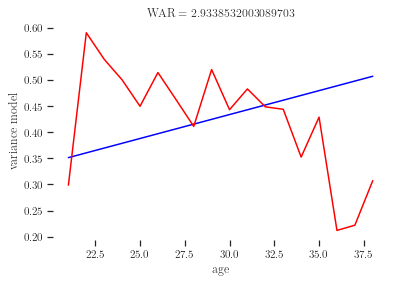

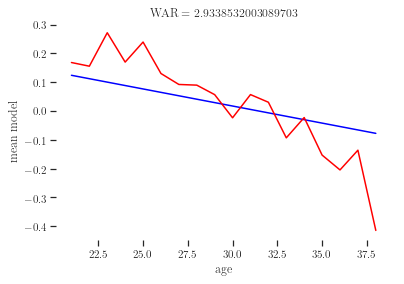

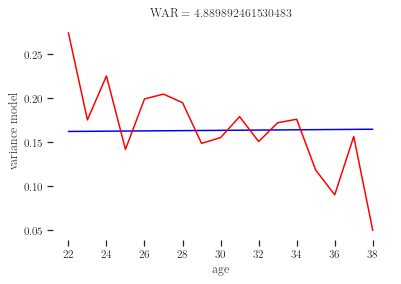

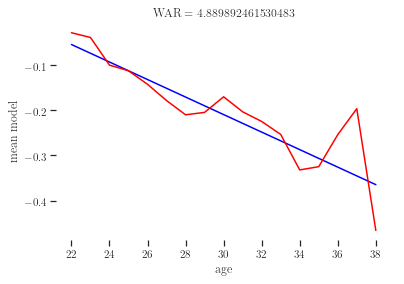

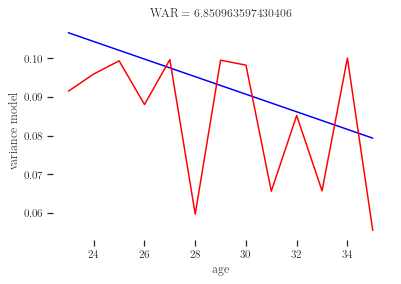

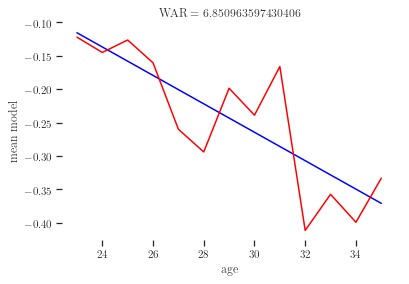

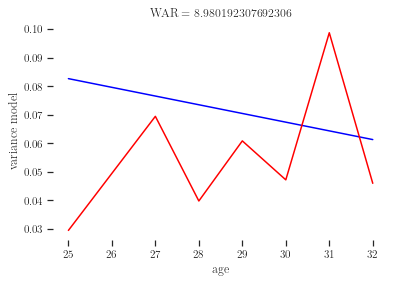

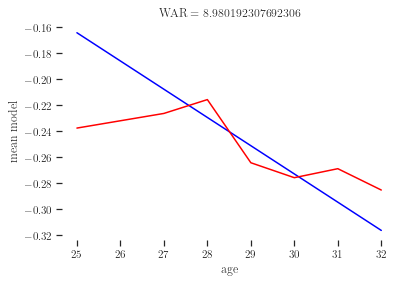

In [18]:
for i in range(N_cutoffs):
    plotData= modelData[modelData['WARbin'] == i];
    
    age_plot= plotData.age.unique();
    
    meanData= plotData.meanDeltaWARperLastWAR;
    varianceData= plotData.varDeltaWARperLastWAR;

    (means, variances)= WARratioModelDist0(age_plot, binMeanLastWAR[i])

    plt.figure();
    plt.plot(age_plot, variances, 'b-');
    plt.plot(age_plot, varianceData, 'r-');
    plt.title('$\mathrm{WAR}= ' + str(binMeanLastWAR[i]) + '$');
    plt.xlabel('age');
    plt.ylabel('variance model');
    plt.show();
    
    plt.figure();
    plt.plot(age_plot, means, 'b-');
    plt.plot(age_plot, meanData, 'r-');
    plt.title('$\mathrm{WAR}= ' + str(binMeanLastWAR[i]) + '$');
    plt.xlabel('age');
    plt.ylabel('mean model');
    plt.show();

eldest troutmi01 season:
	age: 26
	WAR: 10.150000
	model mean interpolation: -0.193864
	model variance interpolation: 0.073572
[[ 5.42917431]
 [ 8.18227947]
 [10.93538462]]


<Figure size 432x288 with 0 Axes>

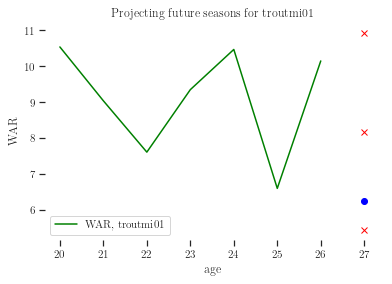

In [19]:
player_ID= 'troutmi01';
# player_ID= 'davisch02';
# player_ID= 'jonesad01';
# player_ID= 'puigya01';
# player_ID= 'bogaexa01';
# player_ID= 'howarry01';

troutData= data[data['player_ID'] == player_ID];

age_eldestTrout= max(troutData.age);
WAR_eldestTrout= troutData[troutData['age'] == age_eldestTrout].WAR.to_numpy();

print "eldest " + player_ID + " season:";
print "\tage: %d" % age_eldestTrout;
print "\tWAR: %f" % WAR_eldestTrout;

(model_mean, model_var)= WARratioModelDist0(age_eldestTrout + 1, WAR_eldestTrout);

print "\tmodel mean interpolation: %f" % model_mean;
print "\tmodel variance interpolation: %f" % model_var;

plt.figure();
ax= troutData.plot(x= 'age', y= 'WAR',
                   c= "green",
                   label= "$\mathrm{WAR}$, " + player_ID);

deltaWARperWAR= np.array([model_mean - np.sqrt(model_var), model_mean, model_mean + 1*np.sqrt(model_var)]);
WARpred= WAR_eldestTrout + deltaWARperWAR*WAR_eldestTrout;
print WARpred;

ax.plot((age_eldestTrout + 1)*np.ones(len(WARpred)), WARpred, 'rx');
# ax.axis([19, 28, 2, 14]);

ax.plot((age_eldestTrout + 1),
        rawData[(rawData['player_ID'] == player_ID) & (rawData['age'] == (age_eldestTrout + 1))].WAR, 'bo');

ax.axis('auto');

plt.title('Projecting future seasons for ' + player_ID);
plt.xlabel('age');
plt.ylabel('$\mathrm{WAR}$');

plt.show();

In [20]:
def predict_WAR(age, lastWAR):
    (model_mean, model_var)= WARratioModelDist0(age, lastWAR);
    model_std= np.sqrt(model_var);
    delta_WAR_mean= model_mean*max(1, lastWAR);
    delta_WAR_std= model_std*max(1, lastWAR);
    WARmean= lastWAR + delta_WAR_mean;
    WAR85= lastWAR + (delta_WAR_mean - delta_WAR_std);
    return (WARmean, WAR85);

In [21]:
data2018qual= rawData[rawData['year_ID'] == 2018].reset_index(drop= True).copy();
data2018qual= data2018qual[data2018qual['PA'] > 502].reset_index(drop= True).copy();

data2018qual['WARpred']= 0.0

In [22]:
for i in range(len(data2018qual)):
    (WARmean, WAR85)= predict_WAR(data2018qual.age[i], data2018qual.lastWAR[i]);
    data2018qual.WARpred[i]= WARmean;
#     print "%f %f\n\n" % (WARmean, WAR85);
#     data2018qual.WARpred[i]= WARmean;

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
data2018qual

G     Inn    OPS_plus     PA        WAR   age  lastG  lastInn  \
0    128.0  1116.7  116.536500  553.0   1.720000  31.0  156.0   1359.0   
1    149.0  1083.3  134.702400  566.0   3.210000  28.0  133.0    533.0   
2    153.0  1239.7   84.013000  564.0   3.200000  28.0   53.0    381.7   
3    158.0  1361.7   99.902800  684.0   3.790000  21.0   57.0    497.3   
4    145.0  1177.3   97.130800  574.0   1.550000  31.0  142.0   1079.0   
5    137.0  1190.7  132.357000  599.0   5.190000  28.0  153.0   1310.3   
6    156.0  1358.0  112.376500  670.0   3.890000  25.0   25.0    198.0   
7    153.0  1338.3   86.440300  606.0   2.520000  25.0  146.0   1264.0   
8    149.0  1295.3  128.557900  606.0   2.210000  23.0    5.0     27.0   
9    156.0  1346.3  131.216600  673.0   5.640000  27.0  159.0   1343.3   
10   160.0  1305.4  128.863700  645.0   6.260000  25.0  145.0   1123.0   
11   138.0  1046.0   86.983300  522.0   0.890000  27.0  121.0    926.3   
12   162.0  1292.7  119.690900  632.0   4.170000  22.0  132.0   1124.0   
13   148.0  1190.3  109.510300  583.0   0.770000  25.0  159.0   1204.3   
14   148.0  1268.3  122.541900  661.0   3.870000  23.0  151.0   1319.3   
15   136.0  1145.0  186.372800  614.0  10.860000  25.0  153.0   1389.3   
16   156.0  1331.3  113.672600  696.0   0.840000  31.0  159.0   1366.3   
17   136.0  1183.3  134.526700  580.0   3.770000  25.0  148.0   1310.3   
18   144.0  1244.7   92.037700  535.0   2.080000  28.0  133.0   1204.3   
19   143.0  1199.3  122.939500  631.0   3.580000  31.0   90.0    749.0   
20   157.0  1404.0  154.660100  705.0   6.880000  24.0  155.0   1334.4   
21   147.0  1155.3  111.353706  592.0   0.744498  32.0  135.0   1020.3   
22   141.0  1180.0  119.129100  620.0   6.900000  32.0  155.0   1302.0   
23   137.0  1148.0   78.818400  552.0   0.740000  30.0  155.0   1338.3   
24   134.0  1096.3  114.568100  524.0   3.700000  24.0   82.0    549.3   
25   144.0  1212.0   92.130300  619.0   1.970000  24.0   38.0    296.3   
26   156.0  1281.0  144.072200  677.0   4.930000  32.0  145.0   1181.3   
27   157.0  1360.3  129.134700  678.0   2.910000  26.0  157.0   1334.3   
28   154.0  1314.0  103.591000  647.0   3.270000  28.0  112.0    954.0   
29   145.0  1273.7  136.555500  616.0   8.150000  25.0   84.0    727.0   
..     ...     ...         ...    ...        ...   ...    ...      ...   
108  136.0  1186.0  137.592700  597.0   4.230000  28.0  147.0   1268.3   
109  153.0  1326.9  123.971300  665.0   2.700000  28.0  157.0   1346.3   
110  153.0  1113.0   80.171700  528.0   2.380000  29.0   90.0    678.0   
111  154.0  1271.7   88.222700  592.0   0.530000  22.0   46.0    374.7   
112  138.0  1191.7  116.455300  592.0   3.640000  26.0  151.0   1266.3   
113  155.0  1337.7   85.998500  662.0   2.600000  26.0  141.0   1118.3   
114  161.0  1394.0  105.277100  679.0   1.730000  32.0  154.0   1341.7   
115  137.0   997.7  117.214300  510.0   1.520000  25.0  129.0    900.0   
116  155.0  1342.7   85.596400  630.0   0.820000  30.0  154.0   1353.3   
117  144.0  1260.7  110.985100  632.0   4.340000  28.0  125.0   1084.0   
118  159.0  1423.7   95.342300  703.0   4.270000  27.0   85.0    747.0   
119  152.0  1189.3  118.665600  587.0   4.090000  28.0  144.0   1235.0   
120  146.0  1263.7  107.635300  600.0   6.170000  28.0  158.0   1369.7   
121  141.0  1143.7  114.409000  544.0   3.520000  25.0   81.0    618.3   
122  147.0  1217.3  122.495400  594.0   2.270000  31.0  158.0   1319.3   
123  122.0  1032.6   80.057200  506.0  -0.740000  30.0  128.0   1043.7   
124  140.0  1198.0  115.359400  620.0   2.740000  28.0  140.0   1183.7   
125  158.0  1422.0  128.874100  705.0   4.010000  28.0  159.0   1348.3   
126  157.0  1372.7  125.110200  656.0   5.580000  25.0  145.0   1185.3   
127  143.0  1229.0  135.119500  606.0   4.210000  26.0  156.0   1305.3   
128  136.0  1165.7   86.105000  533.0   2.340000  24.0  144.0   1202.0   
129  155.0  1179.6  109.545600  604.0   4.130000  27.0  140.0   1102.0   
130  140.0  1

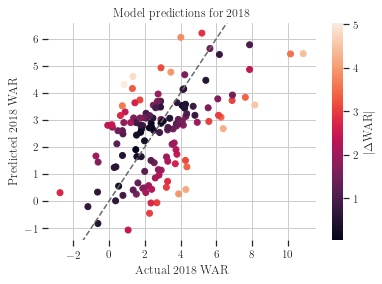

In [24]:
plt.figure();
plt.scatter(x= data2018qual.WAR, y= data2018qual.WARpred,
            c= abs(data2018qual.WAR - data2018qual.lastWAR));
x= (-3, 8);
y= (-3, 8);
plt.title('Model predictions for 2018');
plt.xlabel('Actual 2018 $\mathrm{WAR}$');
plt.ylabel('Predicted 2018 $\mathrm{WAR}$');
cb= plt.colorbar();
cb.set_label('$|\Delta \mathrm{WAR}|$');
cb.outline.set_visible(False);
tmp= plt.axis();
plt.grid();
plt.savefig('../../Saberseminar2019/lecture/graphics/model_backtest.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.plot(x, y, '--', c= 'dimgray');
plt.axis(tmp);
plt.savefig('../../Saberseminar2019/lecture/graphics/model_backtest_line.pdf',
            bbox_inches= 'tight',
            transparent= True);
plt.show();


In [25]:
player_ID= 'puigya01';

player2019age= rawData[(rawData['player_ID'] == player_ID) & (rawData['year_ID'] == 2017)].age.to_numpy() + 1.;
player2019lastWAR= rawData[(rawData['player_ID'] == player_ID) & (rawData['year_ID'] == 2018)].WAR.to_numpy();
player2019goalWAR= 3.0;

(model_mean, model_var)= WARratioModelDist0(player2019age, player2019lastWAR);
zScorePlayerGoal= ((player2019goalWAR - player2019lastWAR)/player2019lastWAR - model_mean)/np.sqrt(model_var)

print player_ID
print model_mean
print model_var
print (player2019goalWAR - player2019lastWAR)/player2019lastWAR
print player2019lastWAR + model_mean*player2019lastWAR
print zScorePlayerGoal

puigya01
[0.1048276]
[0.46955042]
[0.11524164]
[2.97198623]
[0.01519771]


In [73]:
millenialData= rawData[(rawData['year_ID'] >= 1980) & (rawData['year_ID'] <= 2018) & (rawData['PA'] >= 502) & (rawData['WAR'] >= 2.0)].reset_index().copy();
# millenialData= rawData[(rawData['year_ID'] >= 1980) & (rawData['year_ID'] <= 2018) & (rawData['PA'] >= 502)].reset_index().copy();

In [74]:
millenialData['deltaWARperLastWAR']= millenialData.deltaWAR/millenialData.lastWAR;

In [75]:
millenialData['modelVar']= np.nan;
millenialData['deltaWARperLastWARguess']= np.nan;
# millenialData['deltaWARperLastWARguess_m1s']= np.nan;
# millenialData['deltaWARperLastWARguess_p1s']= np.nan;
# millenialData['deltaWARperLastWARguess_m2s']= np.nan;
# millenialData['deltaWARperLastWARguess_p2s']= np.nan;

In [76]:
for i in range(len(millenialData)):
    (model_mean, model_var)= WARratioModelDist0(millenialData.age[i], millenialData.lastWAR[i]);
    millenialData.loc[i, 'deltaWARperLastWARguess']= model_mean;
    millenialData.loc[i, 'modelVar']= model_var;
#     millenialData.loc[i, 'deltaWARperLastWARguess_m1s']= model_mean - np.sqrt(model_var);
#     millenialData.loc[i, 'deltaWARperLastWARguess_p1s']= model_mean + np.sqrt(model_var);
#     millenialData.loc[i, 'deltaWARperLastWARguess_m2s']= model_mean - 2*np.sqrt(model_var);
#     millenialData.loc[i, 'deltaWARperLastWARguess_p2s']= model_mean + 2*np.sqrt(model_var);
millenialData['deltaWARperLastWARguess_msqrt2s']= millenialData.deltaWARperLastWARguess - np.sqrt(2*millenialData.modelVar);
millenialData['deltaWARperLastWARguess_psqrt2s']= millenialData.deltaWARperLastWARguess + np.sqrt(2*millenialData.modelVar);
millenialData['deltaWARperLastWARguess_m2s']= millenialData.deltaWARperLastWARguess - 2*np.sqrt(millenialData.modelVar);
millenialData['deltaWARperLastWARguess_p2s']= millenialData.deltaWARperLastWARguess + 2*np.sqrt(millenialData.modelVar);
millenialData['WARpred']= millenialData.lastWAR + millenialData.lastWAR*millenialData.deltaWARperLastWARguess;
millenialData['modelLikelihood']= st.norm.pdf(np.abs((millenialData.deltaWARperLastWAR - millenialData.deltaWARperLastWARguess)/np.sqrt(millenialData.modelVar)))

In [77]:
float(sum((millenialData.deltaWARperLastWARguess_psqrt2s > millenialData.deltaWARperLastWAR) & (millenialData.deltaWARperLastWAR > millenialData.deltaWARperLastWARguess_msqrt2s)))/float(len(millenialData))

0.6132383496586524

In [78]:
float(sum((millenialData.deltaWARperLastWARguess_p2s > millenialData.deltaWARperLastWAR) & (millenialData.deltaWARperLastWAR > millenialData.deltaWARperLastWARguess_m2s)))/float(len(millenialData))

0.676461858118136

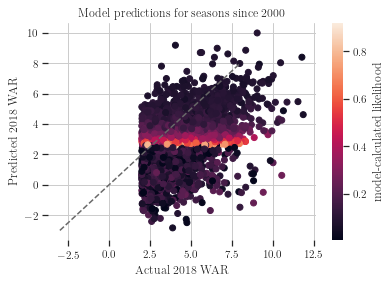

In [82]:
plt.figure();
plt.scatter(x= millenialData.WAR, y= millenialData.WARpred,
            c= millenialData.modelVar);
x= (-3, 8);
y= (-3, 8);
plt.title('Model predictions for seasons since 2000');
plt.xlabel('Actual 2018 $\mathrm{WAR}$');
plt.ylabel('Predicted 2018 $\mathrm{WAR}$');
cb= plt.colorbar();
cb.set_label('model-calculated likelihood');
cb.outline.set_visible(False);
# tmp= plt.axis();
plt.grid();
# plt.savefig('../../Saberseminar2019/lecture/graphics/model_backtest.pdf',
#             bbox_inches= 'tight',
#             transparent= True);
plt.plot(x, y, '--', c= 'dimgray');
# plt.axis(tmp);
# plt.savefig('../../Saberseminar2019/lecture/graphics/model_backtest_line.pdf',
#             bbox_inches= 'tight',
#             transparent= True);
plt.show();


In [81]:
millenialData[millenialData.WARpred < 2]

index      G     Inn  OPS_plus     PA   WAR   age  lastG  lastInn  \
0        64  151.0  1260.3  135.4705  589.0  6.39  24.0   59.0    428.0   
15      143  142.0  1163.0  116.0331  563.0  2.41  25.0  108.0    597.7   
16      235  149.0  1083.3  134.7024  566.0  3.21  28.0  133.0    533.0   
17      257  153.0  1239.7   84.0130  564.0  3.20  28.0   53.0    381.7   
18      280  158.0  1361.7   99.9028  684.0  3.79  21.0   57.0    497.3   
19      328  151.0  1181.3  118.8022  599.0  6.21  23.0  123.0    817.3   
24      348  132.0  1150.7   92.1503  511.0  2.28  29.0   88.0    426.3   
37      580  150.0  1276.3  129.9264  619.0  3.47  30.0  143.0   1206.0   
40      585  155.0  1347.3  131.5346  675.0  3.97  37.0  151.0   1300.0   
41      613  158.0  1371.3  134.7889  707.0  6.07  24.0  152.0   1324.7   
46      641  149.0  1282.0  114.5897  586.0  2.60  25.0   74.0    549.0   
48      722  159.0  1416.0  129.5366  749.0  5.18  28.0  113.0    649.0   
54      729  150.0  1268.0  129.3510  692.0  5.90  35.0  133.0   1085.0   
55      751  156.0  1358.0  112.3765  670.0  3.89  25.0   25.0    198.0   
56      776  154.0  1362.0   91.8271  662.0  3.31  25.0  150.0   1317.0   
57      778  157.0  1378.3  104.2404  660.0  2.74  27.0  156.0   1353.3   
61      818  147.0  1210.7   97.4688  574.0  2.91  27.0   41.0    362.3   
62      820  145.0  1123.3   89.7492  535.0  2.38  29.0  145.0   1198.7   
63      837  153.0  1338.3   86.4403  606.0  2.52  25.0  146.0   1264.0   
64      847  139.0  1130.6   83.5980  511.0  2.56  27.0   16.0    142.0   
65      869  150.0  1270.3   88.6910  665.0  4.16  22.0  148.0   1291.3   
68      873  160.0  1404.7   79.9177  661.0  2.09  26.0  157.0   1345.3   
71      887  149.0  1295.3  128.5579  606.0  2.21  23.0    5.0     27.0   
72      901  145.0  1094.7   95.2458  540.0  2.26  25.0  137.0    903.3   
74      953  153.0  1240.3   89.4927  548.0  2.50  22.0   55.0    464.7   
79     1001  158.0  1423.7  126.7369  666.0  5.91  26.0   80.0    669.3   
81     1005  157.0  1390.0  120.8445  679.0  2.63  30.0  145.0   1232.3   
82     1171  138.0  1161.7   92.7547  573.0  2.25  25.0   15.0     58.0   
88     1249  141.0  1201.0  142.1415  551.0  5.09  24.0  104.0    765.7   
89     1268  136.0  1171.0   77.3920  546.0  2.46  31.0   91.0    685.3   
...     ...    ...     ...       ...    ...   ...   ...    ...      ...   
3230  36625  146.0  1200.7  106.0538  611.0  3.27  33.0  101.0    862.3   
3231  36627  146.0  1219.3  106.3729  627.0  3.75  35.0   74.0    586.7   
3232  36642  145.0  1216.7  113.6187  554.0  3.66  31.0   94.0    824.3   
3237  36694  130.0  1036.0  112.2870  525.0  3.80  23.0   40.0    194.3   
3240  36786  130.0  1078.3   90.3306  502.0  2.61  24.0   96.0    828.3   
3243  36797  144.0  1170.3   94.1568  585.0  4.07  25.0   72.0    540.0   
3245  36849  146.0  1232.0  114.9184  602.0  3.34  26.0  153.0   1220.7   
3256  37010  142.0  1113.7  120.6659  573.0  2.16  27.0   16.0     41.7   
3270  37205  161.0  1363.7  101.7466  650.0  2.57  26.0  132.0    756.0   
3272  37213  157.0  1355.7  104.0386  693.0  4.77  26.0  150.0   1294.7   
3274  37216  135.0  1142.0  105.9683  535.0  3.60  29.0  142.0   1130.0   
3277  37248  161.0  1362.7  108.5018  674.0  2.00  25.0  149.0   1107.0   
3279  37251  155.0  1307.3  112.6498  661.0  2.64  28.0  141.0   1178.7   
3291  37328  156.0  1387.3  138.1563  670.0  4.09  40.0  150.0   1290.0   
3292  37347  152.0  1311.3  119.7239  674.0  4.87  28.0  128.0    990.0   
3297  37457  145.0  1113.0   91.3490  606.0  3.26  34.0  103.0    697.6   
3315  37796  147.0  1256.0  105.7498  680.0  2.70  27.0   44.0    193.0   
3320  37828  156.0  1350.0  107.8995  664.0  5.44  26.0  134.0   1020.3   
3322  37856  155.0  1320.0  143.9902  635.0  3.43  29.0   54.0    451.3   
3324  37867  117.0   977.0  102.2221  513.0  2.47  31.0  155.0   1327.4   
3325  37869  153.0  1284.7   96.5254  690.0  3.32  33.0  119.0    974.3   
3328  37918  156.0  1358.7  127